## PS4: Single Index Models and Minimum Variance Portfolio Allocation
In this problem set, we will use single index models to construct a minimum variance portfolio from a set of risky assets. We will then compare the performance of portfolios constructed using only primary tickers versus those that include low-correlation twin assets. What we will learning about including low-correlation assets in a portfolio optimization context?

> __Learning Objectives:__
> 
> By the end of this example, you should be able to:
> * __Construct SIM-based covariance matrices__ using beta coefficients and market variance rather than direct estimation from historical returns data.
> * __Compute efficient frontiers__ for primary tickers and for primary tickers paired with low-correlation twin assets using SIM-based optimization.
> * __Evaluate portfolio performance__ by comparing wealth trajectories of SIM-based optimized portfolios, assessing the practical value of including low-correlation assets.

Let's get started!
yipeee
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [`include(...)` command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file, `Include.jl`, in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, etc. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/). 

Let's set up our code environment:

In [1]:
include(joinpath(@__DIR__, "Include-solution.jl")); # include the Include.jl file

For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/) and the [VLQuantitativeFinancePackage.jl documentation](https://github.com/varnerlab/VLQuantitativeFinancePackage.jl). 

### Data
We gathered daily open-high-low-close (OHLC) data for each firm in the [S&P 500](https://en.wikipedia.org/wiki/S%26P_500) from `01-03-2025` to `09-26-2025`, along with data for several exchange-traded funds and volatility products during that time period.

Let's load the `original_dataset::DataFrame` by calling [the `MyTestingMarketDataSet()` function](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/data/#VLQuantitativeFinancePackage.MyTestingMarketDataSet).

In [2]:
original_dataset = MyTestingMarketDataSet() |> x-> x["dataset"] # load the original dataset (testing)

Dict{String, DataFrame} with 482 entries:
  "NI"   => 182×8 DataFrame…
  "EMR"  => 182×8 DataFrame…
  "CTAS" => 182×8 DataFrame…
  "HSIC" => 182×8 DataFrame…
  "KIM"  => 182×8 DataFrame…
  "PLD"  => 182×8 DataFrame…
  "IEX"  => 182×8 DataFrame…
  "BAC"  => 182×8 DataFrame…
  "CBOE" => 182×8 DataFrame…
  "EXR"  => 182×8 DataFrame…
  "NCLH" => 182×8 DataFrame…
  "CVS"  => 182×8 DataFrame…
  "DRI"  => 182×8 DataFrame…
  "DTE"  => 182×8 DataFrame…
  "ZION" => 182×8 DataFrame…
  "AVY"  => 182×8 DataFrame…
  "EW"   => 182×8 DataFrame…
  "EA"   => 182×8 DataFrame…
  "NWSA" => 182×8 DataFrame…
  ⋮      => ⋮

Not all tickers in our dataset have the maximum number of trading days for various reasons, such as acquisition or delisting events. Let's collect only those tickers with the maximum number of trading days.

First, let's compute the number of records for a firm that we know has the maximum value, e.g., `AAPL`, and save that value in the `maximum_number_trading_days::Int64` variable:

In [3]:
maximum_number_trading_days = original_dataset["AAPL"] |> nrow; # maximum number of trading days in our dataset

Now, let's iterate through our data and collect only tickers with `maximum_number_trading_days` records. Save that data in the `dataset::Dict{String,DataFrame}` variable:

In [4]:
dataset = let

    # initialize -
    dataset = Dict{String, DataFrame}();

    # iterate through the dictionary; we can't guarantee a particular order
    for (ticker, data) ∈ original_dataset  # we get each (K, V) pair!
        if (nrow(data) == maximum_number_trading_days) # check if ticker has maximum trading days
            dataset[ticker] = data;
        end
    end
    dataset; # return
end;

Let's get a list of the firms in our cleaned dataset and sort them alphabetically. We store the sorted firm ticker symbols in the `list_of_tickers_price_data::Array{String,1}` variable:

In [5]:
list_of_tickers_price_data = keys(dataset) |> collect |> sort;

Finally, let's load the single index model parameters that we computed in the previous example. We'll store this data in the `sim_model_parameters::Dict{String,NamedTuple}` variable. In addition, we return a few other useful variables, such as the historical market growth rate, the mean and variance of the market growth, etc.

In [6]:
sim_model_parameters,Gₘ,Ḡₘ, Varₘ = let

    # initialize -
    path_to_sim_model_parameters = joinpath(_PATH_TO_DATA,"SIMs-SPY-SP500-01-03-14-to-12-31-24.jld2");
    sim_model_parameters = JLD2.load(path_to_sim_model_parameters);
    parameters = sim_model_parameters["data"]; # return

    Gₘ = sim_model_parameters["Gₘ"]; # Get the past market growth rate 
    Ḡₘ = sim_model_parameters["Ḡₘ"]; # mean of market growth rates
    Varₘ = sim_model_parameters["Varₘ"]; # variance of market growth

    # return -
    parameters,  Gₘ , Ḡₘ, Varₘ;
end;

In [7]:
Varₘ

4.6009258866223846

Now let's get a list of all tickers for which we have single index model parameters:

In [8]:
tickers_that_we_computed_sim_data_for = keys(sim_model_parameters) |> collect |> sort;

We need to use only the tickers for which we have both price data and SIM parameters. We'll compute [the intersection of the two lists](https://docs.julialang.org/en/v1/base/collections/#Base.intersect) and store the result in the `list_of_tickers::Array{String,1}` variable:

In [9]:
list_of_tickers = intersect(tickers_that_we_computed_sim_data_for, list_of_tickers_price_data);

### Constants
Finally, let's set some constants we'll use later in this notebook. The comments describe the constants, their units, and permissible values:

In [10]:
risk_free_rate = 0.0389; # hypothetical continuous compounded risk free rate (units: 1/year)
Δt = (1.0/252.0); # time step for 1-trading day (units: 1/year)
number_of_points = 301; # number of points on the efficient frontier that we want to compute
budget_in_risky_assets = 1000.0; # budget in USD to invest in risky assets

# Named constants for plotting and analysis
const PLOT_SKIP_FACTOR = 8; # skip every N points when plotting scatter markers
const PLOT_FONT_SIZE = 18; # font size for plot labels
const AXIS_LIMIT_MULTIPLIER = 1.1; # multiplier for axis limits (10% padding)

___

## Task 1: Risk and Return Matrices For Low Correlation Ticker Pairs
In this task, we will set up the risk and return matrices that we will use in the minimum variance portfolio allocation. We'll do two versions: one using the primary tickers and another using the primary tickers paired with their low-correlation twins.

Let's start by specifying a collection of ticker symbols, e.g., `AAPL`, `MSFT`, etc., that interest you in the `my_primary_list_of_tickers::Array{String,1}` array.

In [11]:
my_primary_list_of_tickers = ["AAPL", "MSFT", "INTC", "MU", "AMD", "GS", "BAC", "WFC", "C", "F", "GM", 
    "JNJ", "PG", "UPS", "COST", "TGT", "WMT", "MRK", "PFE", "ADBE"]; # tickers selected for portfolio

### Compute Low-Correlation Ticker Pairs
Now that we have our primary list of tickers, let's compute the lowest correlation twin using the correlation written in terms of the single index model parameters. The correlation between firms $i$ and $j$ ($i\neq j$) is given by:
$$
\boxed{
\begin{align*}
\rho_{ij}
&=\frac{\beta_i\beta_j\sigma_M^2}
{\sqrt{\big(\beta_i^2\sigma_M^2+\sigma_{\epsilon_i}^2\big)\big(\beta_j^2\sigma_M^2+\sigma_{\epsilon_j}^2\big)}}\\
\end{align*}}
$$
where $\beta_i$ and $\beta_j$ are the single index model beta coefficients for firms $i$ and $j$, respectively, $\sigma_{M}^2$ is the market variance, and $\sigma_{\epsilon_i}^2$ and $\sigma_{\epsilon_j}^2$ are the idiosyncratic variances for firms $i$ and $j$, respectively.

First, let's compute the correlation matrix for all firms in our dataset using the SIM parameters. We'll store the correlation matrix in the `CM::Array{Float64,2}` variable:

In [12]:
CM = let

    # initialize -
    number_of_tickers = length(list_of_tickers);
    correlation_matrix = Array{Float64,2}(undef, number_of_tickers, number_of_tickers);
    σ²ₘ = Varₘ; # market variance

    for i ∈ eachindex(list_of_tickers)
        
        ticker_i = list_of_tickers[i];
        data_i = sim_model_parameters[ticker_i]; # get the data for ticker i
        βᵢ = data_i.beta; # get beta for ticker i
        σ²_εᵢ = (Δt)*data_i.training_variance; # residual variance for ticker i

        for j ∈ eachindex(list_of_tickers)

            ticker_j = list_of_tickers[j];
            data_j = sim_model_parameters[ticker_j]; # get the data for ticker j
            βⱼ = data_j.beta; # get beta for ticker j
            σ²_εⱼ = (Δt)*data_j.training_variance; # residual variance for ticker j

            if (i == j)
                correlation_matrix[i,j] = 1.0; # variance case
            else
                covariance_ij = (βᵢ*βⱼ*σ²ₘ);
                correlation_ij = covariance_ij / sqrt( (βᵢ^2*σ²ₘ + σ²_εᵢ)*(βⱼ^2*σ²ₘ + σ²_εⱼ) );
                correlation_matrix[i,j] = correlation_ij;
            end
        end
    end
    correlation_matrix;
end;

Next, let's find the lowest correlation twin for each firm in our primary list of tickers. We'll store the primary tickers and their low-correlation twins in the `my_list_of_ticker_pairs::Array{Tuple{String,String},1}` variable:

In [13]:
my_list_of_ticker_pairs = let

    # initialize -
    my_list_of_twin_tickers = Set{String}();
    
    for i ∈ eachindex(my_primary_list_of_tickers)

        primary_ticker = my_primary_list_of_tickers[i];
        primary_index = findfirst(isequal(primary_ticker), list_of_tickers);
        correlations_with_primary = CM[primary_index, :];

        # get correlations for this primary ticker
        correlations_with_primary = CM[primary_index, :];
        
        # create a list of (correlation, index) pairs, excluding self
        correlation_pairs = [(correlations_with_primary[j], j) for j in eachindex(correlations_with_primary) if j != primary_index];
        
        # sort by correlation ascending (lowest first)
        sort!(correlation_pairs, by = x -> x[1]);
        
        # find the first unused twin
        twin_index = nothing;
        for (corr, idx) in correlation_pairs
            candidate_ticker = list_of_tickers[idx];
            if (candidate_ticker ∈ my_list_of_twin_tickers) == false && (candidate_ticker ∈ my_primary_list_of_tickers) == false
                twin_index = idx;
                break;
            end
        end
        
        # if we found a twin, add it to the my_list_of_tickers -
        if twin_index !== nothing
            twin_ticker = list_of_tickers[twin_index];
            push!(my_list_of_twin_tickers, twin_ticker);
        end
    end
    a = my_list_of_twin_tickers |> collect |> sort;
    b = my_primary_list_of_tickers;
    c = [(b[i], a[i]) for i ∈ eachindex(b)];
    c;
end;

Let's display the primary tickers and their low-correlation twin pairs, along with the correlation values between them:

In [14]:
let

    # initialize -
    number_of_ticker_pairs = length(my_list_of_ticker_pairs);
    df = DataFrame();
    
    for i ∈ 1:number_of_ticker_pairs

        # get the ticker pair -
        (ticker_1, ticker_2) = my_list_of_ticker_pairs[i];

        # get indices in the master list -
        index_1 = findfirst(isequal(ticker_1), list_of_tickers);
        index_2 = findfirst(isequal(ticker_2), list_of_tickers);

        # get correlation -
        correlation = CM[index_1, index_2];

        # add to dataframe -
        push!(df, (primary = ticker_1, twin = ticker_2, correlation = correlation));
    end
    
    pretty_table(
        df;
        backend = :text,
        fit_table_in_display_vertically = false,
        table_format = TextTableFormat(borders = text_table_borders__compact)
    );
end

 --------- -------- -------------
  primary     twin   correlation 
   String   String       Float64 
 --------- -------- -------------
     AAPL      CAG      0.168155
     MSFT      CHD      0.101521
     INTC      CLX     0.0975747
       MU      CPB     0.0960641
      AMD       DG      0.134646
       GS       ED      0.206699
      BAC      GIS      0.166836
      WFC      GLD     0.0119758
        C      HBI      0.177567
        F      HRL        0.1526
       GM       IR      0.189222
      JNJ        K      0.109987
       PG       KR     0.0744816
      UPS       MA     0.0906619
     COST      NEM     0.0856383
      TGT       NI     0.0910065
      WMT      SJM     0.0833706
      MRK      SLV     0.0808852
      PFE     TECH     0.0927851
     ADBE      UNG     0.0519089
 --------- -------- -------------


Now combine the primary tickers and their twins into a single list for use in the next calculations. We'll save the combined ticker list (primary + twins) in the `my_list_of_twin_tickers::Array{String,1}` variable:

In [15]:
my_list_of_twin_tickers = let

    # initialize -
    my_list_of_tickers = Array{String,1}();
    for (ticker_1, ticker_2) ∈ my_list_of_ticker_pairs
        push!(my_list_of_tickers, ticker_1);
        push!(my_list_of_tickers, ticker_2);
    end
    my_list_of_tickers;
end;

### SIM-Based Risk and Return Matrices
Now we'll compute the expected return vector and covariance matrix using the single index model for the primary list of tickers and their low-correlation twins.

We'll use the SIM formula for expected returns and the SIM-derived covariance structure. Store these in the `ĝ_sim_primary::Array{Float64,1}` and `Σ̂_sim_primary::Array{Float64,2}` variables:

In [16]:
ĝ_sim_primary, Σ̂_sim_primary = let

    # initialize -
    local_list_of_tickers = my_primary_list_of_tickers;
    N = length(local_list_of_tickers); # number of assets in portfolio
    μ_sim = Array{Float64,1}(); # drift vector
    Σ̂_sim = Array{Float64,2}(undef, N, N); # covariance matrix for *our* portfolio
    Ḡₘ = mean(Gₘ); # average market factor -
    σ²ₘ = var(Gₘ); # variance of market factor

    # compute the expected growth rate (return) for each of our tickers -
    for i ∈ eachindex(local_list_of_tickers)
        ticker = local_list_of_tickers[i];
        data = sim_model_parameters[ticker]; # get the data for this ticker
        αᵢ = data.alpha; # get alpha
        βᵢ = data.beta; # get beta
        Ḡᵢ = αᵢ + βᵢ* Ḡₘ; # compute the growth rate for this ticker
        push!(μ_sim, Ḡᵢ); # append drift value to μ_sim
    end

    # compute the covariance matrix using the single index model -
    for i ∈ eachindex(local_list_of_tickers)

        ticker_i = local_list_of_tickers[i];
        data_i = sim_model_parameters[ticker_i]; # get the data for ticker i
        βᵢ = data_i.beta; # get beta for ticker i
        σ²_εᵢ = (Δt)*data_i.training_variance; # residual variance for ticker i

        for j ∈ eachindex(local_list_of_tickers)
            
            ticker_j = local_list_of_tickers[j];
            data_j = sim_model_parameters[ticker_j]; # get the data for ticker j
            βⱼ = data_j.beta; # get beta for ticker j
            σ²_εⱼ = (Δt)*data_j.training_variance; # residual variance for ticker j
            
            if i == j
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ + σ²_εᵢ; # diagonal elements
            else
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ; # off-diagonal elements
            end
        end
    end

    (μ_sim, Σ̂_sim*Δt); # return
end;

and the twin growth rates and covariance matrix (which we will use later) in the `ĝ_sim_twins::Array{Float64,1}` and `Σ̂_sim_twins::Array{Float64,2}` variables:

In [40]:
ĝ_sim_twins, Σ̂_sim_twins = let

    # initialize -
    local_list_of_tickers = my_list_of_twin_tickers;
    N = length(local_list_of_tickers); # number of assets in portfolio
    μ_sim = Array{Float64,1}(); # drift vector
    Σ̂_sim = Array{Float64,2}(undef, N, N); # covariance matrix for *our* portfolio
    Ḡₘ = mean(Gₘ); # average market factor -
    σ²ₘ = var(Gₘ); # variance of market factor

    # TODO: Uncomment to compute the expected growth rate (return) for each of our tickers -
    # TODO: Once you uncommented the code below, don't forget to comment out the ErrorException line
    #throw(ErrorException("Ooops! Need to compute the expected growth rate (return) for each of our tickers"));
    # compute the expected growth rate (return) for each of our tickers -
    for i ∈ eachindex(local_list_of_tickers)
        ticker = local_list_of_tickers[i];
        data = sim_model_parameters[ticker]; # get the data for this ticker
        αᵢ = data.alpha; # get alpha
        βᵢ = data.beta; # get beta
        Ḡᵢ = αᵢ + βᵢ* Ḡₘ; # compute the growth rate for this ticker
        push!(μ_sim, Ḡᵢ); # append drift value to μ_sim
    end

    # TODO: Uncomment to compute the covariance matrix using the single index model -
    # TODO: Once you uncommented the code below, don't forget to comment out the ErrorException line
    #throw(ErrorException("Ooops! Need to compute the expected growth rate (return) for each of our tickers"));
    # compute the covariance matrix using the single index model -
    for i ∈ eachindex(local_list_of_tickers)

        ticker_i = local_list_of_tickers[i];
        data_i = sim_model_parameters[ticker_i]; # get the data for ticker i
        βᵢ = data_i.beta; # get beta for ticker i
        σ²_εᵢ = (Δt)*data_i.training_variance; # residual variance for ticker i

        for j ∈ eachindex(local_list_of_tickers)
            
            ticker_j = local_list_of_tickers[j];
            data_j = sim_model_parameters[ticker_j]; # get the data for ticker j
            βⱼ = data_j.beta; # get beta for ticker j
            σ²_εⱼ = (Δt)*data_j.training_variance; # residual variance for ticker j
            
            if i == j
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ + σ²_εᵢ; # diagonal elements
            else
                Σ̂_sim[i,j] = βᵢ*βⱼ*σ²ₘ; # off-diagonal elements
            end
        end
    end

    (μ_sim, Σ̂_sim*Δt); # return
end;

___

## Task 2: Compute the efficient frontiers for your collection of tickers
Now we compute efficient frontiers using SIM-based optimization. We will calculate the efficient frontier for the primary tickers, and then for the primary tickers paired with low-correlation twins. This allows us to compare how the inclusion of low-correlation assets affects the efficient frontier.

Build an instance of the [MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem type](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem) using a custom [build(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.build-Tuple{Type{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem},%20NamedTuple}) for the tickers in your primary list. We'll store this in the `problem_sim_primary::MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem` variable:

In [42]:
problem_sim_primary = let

    # initialize -
    local_list_of_tickers = my_primary_list_of_tickers;
    number_of_firms = length(local_list_of_tickers);
    wₒ = zeros(number_of_firms);
    wₒ[1] = 1.0;
    bounds = zeros(number_of_firms,2);
    bounds[:,2] .= 1.0;

    # Build the Markowitz problem instance -
    problem_sim_primary = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
        Σ = Σ̂_sim_primary, # sim cov matrix
        μ = ĝ_sim_primary, # sim expected array
        bounds = bounds,
        initial = wₒ,
        R = 0.0
    ));

    problem_sim_primary; # return
end;

Next, create a similar instance for the tickers in your primary list paired with their low-correlation twins. Store this in the `problem_sim_twins::MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem` variable:

In [43]:
problem_sim_twins = let

    # initialize -
    local_list_of_tickers =  my_list_of_twin_tickers;
    number_of_firms = length(local_list_of_tickers);
    wₒ = zeros(number_of_firms);
    wₒ[1] = 1.0;
    bounds = zeros(number_of_firms,2);
    bounds[:,2] .= 1.0;
    

    # TODO: Build the Markowitz problem instance for the twin tickers. Once done, don't forget to comment out the ErrorException line
    #throw(ErrorException("Ooops! Need to build the Markowitz problem instance for the twin tickers"));
    
    # Build the Markowitz problem instance -
    problem_sim_twins = build(MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem, (
        Σ = Σ̂_sim_twins, # sim cov matrix
        μ = ĝ_sim_twins, # sim expected array
        bounds = bounds,
        initial = wₒ,
        R = 0.0
    ));

    problem_sim_twins; # return
end;

Now that we have both problems set up, we need to create an array with the minimum desired rewards (the calculation must achieve at least this much reward). In this case, assume we go from the risk-free rate to some multiple of the risk-free rate, taking `number_of_points::Int64` steps.  

We store these values in the `minimum_desired_reward_array::Array{Float64,1}` variable:

In [44]:
minimum_desired_reward_array = range(risk_free_rate, stop = 10*risk_free_rate, length = number_of_points) |> collect; # range from risk-free rate to 10x risk-free rate

We now iterate through the `minimum_desired_reward_array::Array{Float64,1}` and compute the minimum risk required to achieve the specified reward level using a `for` loop.

For each pass through the loop, we:
* Update the `problem` variable with the minimum desired reward (set the `R` field). We then pass the updated `problem` object to the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) (which initializes and solves the optimization problem). The solution returned from the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) is stored in the `solution` dictionary. 
* We check the `status` of the solution. If the `status` indicates an optimal solution was found, we store that solution in the `efficient_frontier` dictionary. In particular, we store the portfolio risk as the `key` and the expected return, risk, and allocation as the `value` in the `efficient_frontier` dictionary.

Why the [try-catch environment](https://docs.julialang.org/en/v1/base/base/#try)? The [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) has an [@assert statement](https://docs.julialang.org/en/v1/base/base/#Base.@assert) to check if the calculation has converged. Thus, the solve method can [throw](https://docs.julialang.org/en/v1/base/base/#Core.throw) an [AssertionError](https://docs.julialang.org/en/v1/base/base/#Core.AssertionError) if the optimization problem fails to converge. To gracefully handle this case, we use a [try-catch construct](https://docs.julialang.org/en/v1/base/base/#try). See the [is_solved_and_feasible method from the JuMP package](https://jump.dev/JuMP.jl/stable/api/JuMP/#JuMP.is_solved_and_feasible) for more information.

In [46]:
efficient_frontier_sim_primary = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();
    problem_model = problem_sim_primary; # alias the problem so we can change it later

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_model.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value

        try
            solution = solve(problem_model)
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # extract the optimal allocation
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            #println("Failed: desired R = $(problem_sim.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

Next, do the same for the problem instance that includes the low-correlation twins. Store the efficient frontier in the `efficient_frontier_sim_twins::Dict{Float64, NamedTuple}` variable:

In [48]:
efficient_frontier_sim_twins = let

    # initialize -
    efficient_frontier = Dict{Float64, NamedTuple}();
    problem_model = problem_sim_twins; # alias the problem so we can change it later

    # main loop
    for i ∈ eachindex(minimum_desired_reward_array)
        problem_model.R = minimum_desired_reward_array[i]; # update the problem object with the min desired reward value

        try
            # TODO: Uncomment to solve the problem for the twin tickers. Once done, don't forget to comment out the ErrorException line
            #throw(ErrorException("Ooops! Need to solve the problem for the twin tickers"));
            solution = solve(problem_model) # call's the solve function to compute optimal allocation
            status_flag = solution["status"];    

            if (status_flag == MathOptInterface.LOCALLY_SOLVED)
                risk_value = solution["objective_value"]; # get the sqrt of the risk
                reward_value = solution["reward"];
                allocation = solution["argmax"]; # extract the optimal allocation
                efficient_frontier[risk_value] = (risk = risk_value, reward = reward_value, w = allocation)
            end
        catch err
            # Uncomment to see which R's failed ...
            # println("Failed: desired R = $(problem_sim.R). Infeasible");
        end    
    end
    efficient_frontier;
end;

So what do we get stored in the efficient frontier dictionaries?

In [49]:
efficient_frontier_sim_twins

Dict{Float64, NamedTuple} with 235 entries:
  0.0185359  => (risk = 0.0185359, reward = 0.188276, w = [0.203401, -6.75744e-…
  0.00749771 => (risk = 0.00749771, reward = 0.12059, w = [0.0730221, 1.0245e-8…
  0.0221831  => (risk = 0.0221831, reward = 0.201113, w = [0.230821, 5.71574e-8…
  0.0496527  => (risk = 0.0496527, reward = 0.24896, w = [0.41953, 1.80237e-9, …
  0.00396685 => (risk = 0.00396685, reward = 0.0429955, w = [8.71291e-9, 0.0263…
  0.0159483  => (risk = 0.0159483, reward = 0.177773, w = [0.180966, 8.81868e-8…
  0.165178   => (risk = 0.165178, reward = 0.297974, w = [0.176997, -7.20876e-9…
  0.00792649 => (risk = 0.00792649, reward = 0.125258, w = [0.0797149, 8.0696e-…
  0.00850314 => (risk = 0.00850314, reward = 0.131093, w = [0.0887203, 5.23091e…
  0.00519833 => (risk = 0.00519833, reward = 0.087914, w = [0.0269317, 1.93359e…
  0.00654056 => (risk = 0.00654056, reward = 0.10892, w = [0.0566954, 1.8563e-8…
  0.0154218  => (risk = 0.0154218, reward = 0.175439, w = [0.1759

### Organize efficient frontier results into a matrix for analysis and visualization
Transform the `efficient_frontier::Dict{Float64,NamedTuple}` dictionaries into a matrix format for plotting and analysis.

> __What are we doing?__ Extract portfolio data from the `efficient_frontier::Dict{Float64,NamedTuple}` dictionary and organize it into the `results_array_sim::Array{Float64,2}` matrix. Sort portfolios by risk level and store risk, return, and allocation weights in matrix columns.

> __What's in the results array?__ The `results_array_sim::Array{Float64,2}` has `number_of_portfolios::Int64` rows and `M+2` columns:
> * Column 1: Sorted portfolio risk (standard deviation = √variance). Sorted from lowest to highest risk  
> * Column 2: Portfolio expected return
> * Columns 3 to M+2: Asset allocation weights for the `M::Int64` tickers

Let's build the `results_array_sim_primary::Array{Float64,2}` from our efficient frontier solutions:

In [50]:
results_array_sim_primary = let

    # initialize -
    efficient_frontier = efficient_frontier_sim_primary; # alias the efficient frontier
    local_list_of_tickers = my_primary_list_of_tickers; # alias the ticker list

    # Build the results array -
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(local_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array # return
end

235×22 Matrix{Float64}:
 0.0982403  0.0711543  4.86749e-7    5.89934e-7  …   0.0971825    3.77918e-7
 0.0982403  0.0711549  4.86809e-7    5.8994e-7       0.097181     3.77959e-7
 0.0982403  0.0711561  4.86806e-7    5.90016e-7      0.0971777    3.77941e-7
 0.0982403  0.071154   4.93306e-7    5.9504e-7       0.0971832    3.80204e-7
 0.0982403  0.071154   4.94565e-7    5.96067e-7      0.0971833    3.8045e-7
 0.0982403  0.071154   4.91938e-7    5.93896e-7  …   0.0971832    3.7996e-7
 0.0982403  0.071154   4.95567e-7    5.96867e-7      0.0971833    3.80635e-7
 0.0982403  0.071154   4.96379e-7    5.97503e-7      0.0971833    3.80779e-7
 0.0982403  0.071154   4.9705e-7     5.98019e-7      0.0971833    3.80894e-7
 0.0982403  0.071154   4.9008e-7     5.92313e-7      0.0971832    3.7959e-7
 ⋮                                               ⋱   ⋮           
 0.428582   0.302642   0.118049      6.28837e-8     -7.41751e-9   2.52654e-9
 0.434201   0.303809   0.103313      5.95465e-8     -7.46805e-9   

Next, do the same for data in the `efficient_frontier_sim_twins::Dict{Float64,NamedTuple}` dictionary. Store the results in the `results_array_sim_twins::Array{Float64,2}` variable:

In [52]:
results_array_sim_twins = let

    # initialize -
    efficient_frontier = efficient_frontier_sim_twins; # alias the efficient frontier
    local_list_of_tickers = my_list_of_twin_tickers; # alias the ticker list

    # TODO: Build the results array -
    # TODO: Uncomment to build the results array for the twin tickers. Once done, don't forget to comment out the ErrorException line
    #throw(ErrorException("Ooops! Need to build the results array for the twin tickers"));
    number_of_portfolios = length(efficient_frontier); # how many portfolios do we have? (these all exited correctly)
    M = length(local_list_of_tickers); # how many tickers do we have?
    results_array = Array{Float64,2}(undef, number_of_portfolios, M+2);
    risk_array_sorted = keys(efficient_frontier) |> collect |> sort;

    for i ∈ eachindex(risk_array_sorted)
        risk_value = risk_array_sorted[i] |> sqrt; # let's plot the sqrt of the risk
        
        data = efficient_frontier[risk_array_sorted[i]] # get the NamedTuple corresponding to this risk level
        reward_value = data.reward;
        w = data.w;

        results_array[i,1] = risk_value;
        results_array[i,2] = reward_value;
        for j ∈ 1:M
            results_array[i,2+j] = w[j];
        end
    end

    results_array # return

    results_array # return
end

235×42 Matrix{Float64}:
 0.0629829  0.0429946  8.50156e-9    0.0263248   …   6.23323e-9    0.0106875
 0.062983   0.0429953  8.69903e-9    0.0263249       6.34677e-9    0.0106881
 0.062983   0.0429955  8.71291e-9    0.0263249       6.35521e-9    0.0106881
 0.062983   0.0429955  8.71708e-9    0.0263249       6.35764e-9    0.0106881
 0.0629852  0.0435713  4.65571e-7    0.0259062       4.0214e-7     0.0101639
 0.0629978  0.0447359  4.85376e-7    0.0251342   …   4.12345e-7    0.00923788
 0.0630221  0.0459028  5.06711e-7    0.0243643       4.22883e-7    0.0083166
 0.0630579  0.0470695  5.29707e-7    0.0235963       4.33881e-7    0.0073987
 0.0631053  0.0482364  5.54907e-7    0.0228282       4.45474e-7    0.00648089
 0.0631643  0.0494033  5.82589e-7    0.0220601       4.57694e-7    0.00556309
 ⋮                                               ⋱   ⋮            
 0.428582   0.302642   0.11805      -7.43547e-9      2.52655e-9   -8.75601e-9
 0.434201   0.303809   0.103313     -7.48601e-9      2.244

### Visualize the Efficient Frontier
With our efficient frontiers computed and organized into matrix format, we can now visualize the classic risk-return trade-off that Markowitz theory reveals. The efficient frontier shows the boundary of achievable risk-return combinations for our selected assets.

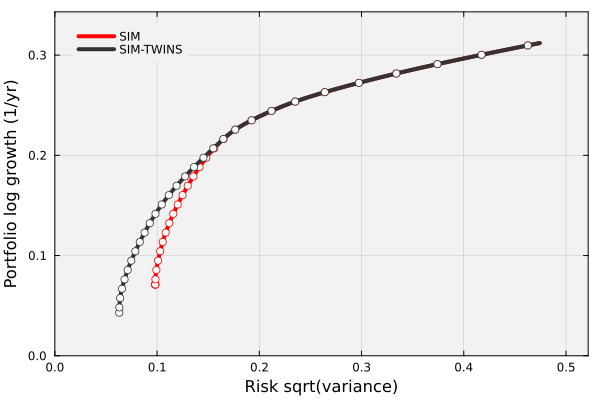

In [53]:
let

    # initialize -
    skip = PLOT_SKIP_FACTOR;

    # -- PRIMARY TICKERS SIM PLOT START --------------------------------------------------------------------- #
    results_array = results_array_sim_primary; # alias the results array
    efficient_frontier = efficient_frontier_sim_primary; # alias the efficient frontier
    max_risk_value = results_array[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios_sim = length(efficient_frontier); # how many portfolios did we recover?
    plot(results_array[:,1], results_array[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=PLOT_FONT_SIZE, label="SIM", c=:red, 
        xlim=(0.0, AXIS_LIMIT_MULTIPLIER*max_risk_value), ylim = (0.0, AXIS_LIMIT_MULTIPLIER*max_reward_value))
    scatter!(results_array[1:skip:number_of_portfolios_sim,1], results_array[1:skip:number_of_portfolios_sim,2], 
        label="", c=:white, ms=4, msc=:red)
    
    # --PRIMARY TICKERS SIM PLOT END ----------------------------------------------------------------------- #

    # -- TWIN TICKERS SIM PLOT START ----------------------------------------------------------------------- #
    results_array = results_array_sim_twins; # alias the results array
    efficient_frontier = efficient_frontier_sim_twins; # alias the efficient frontier

    max_risk_value = results_array[end,1]; # what is the biggest risk we have (x-axis value)
    max_reward_value = results_array[end,2]; # what is the biggest reward that we have (y-axis value)
    number_of_portfolios_sim = length(efficient_frontier); # how many portfolios did we recover?
    plot!(results_array[:,1], results_array[:,2], lw=4, xlabel="Risk sqrt(variance)", 
        ylabel="Portfolio log growth (1/yr)", fontsize=PLOT_FONT_SIZE, label="SIM-TWINS", c=:gray20, 
        xlim=(0.0, AXIS_LIMIT_MULTIPLIER*max_risk_value), ylim = (0.0, AXIS_LIMIT_MULTIPLIER*max_reward_value))
    scatter!(results_array[1:skip:number_of_portfolios_sim,1], results_array[1:skip:number_of_portfolios_sim,2], 
        label="", c=:white, ms=4, msc=:gray20)
    # -- TWIN TICKERS SIM PLOT END ------------------------------------------------------------------------- #

    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);

end

### Discussion Question for Task 2

__Question:__ Examine the two efficient frontiers plotted above (the primary tickers SIM portfolio in red and the primary+twins SIM portfolio in gray). The primary+twins portfolio includes low-correlation assets paired with each original ticker.

Compare the shape, position, and risk-return characteristics of these two efficient frontiers. Specifically:
1. Which efficient frontier offers better risk-adjusted returns (higher return for the same risk, or lower risk for the same return)?
2. What does this tell you about the benefit of including low-correlation assets in a portfolio?
3. How does diversification through low-correlation assets affect the efficient frontier's position and curvature?

Provide your analysis and interpretation below, supporting your conclusions with specific observations from the plot.

__Answers here:__ 
Question 1: The efficient frontier that offers better risk-adjusted returns is the SIM-TWINS as it provides a higher portfolio log growth at lower risk variance. In comparison to SIM, it results in higher return for the same risk. 
Question 2: The benefit of including low-correlation assets in a portfolio results in greater diversication. This can been seen with the higher returns for the same risk, as well as expands the boundary of achievable risk-return combinations. 
Question 3: Diversification through low-correlation assets affect the efficient frontier's position and curvature as seen in the SIM-TWINS curvature, it has moved to the left and up, revealing a larger variance and broader efficiencies across the portfolios. Additionally, it adds to the possibility of higher returns at lower risks. It's essentially more efficient.  

In [27]:
did_I_answer_the_discussion_questions_task_2 = true; # set to {true | false} if you answered the discussion question

___

## Task 3: Portfolio Performance Evaluation
We now evaluate the actual wealth trajectories of portfolios constructed using the SIM-based allocations from Task 2. We compare the primary, primary+twins, and SPY portfolios to assess real-world portfolio performance.

To begin, specify a desired portfolio growth rate in the `desired_growth_rate::Float64` variable:

In [54]:
desired_growth_rate = 0.20; # select a desired *excess* return where both approaches have data

Next, let's (re)resolve the minimum variance problem for the primary list of tickers, and the low-correlation twins using the same desired growth rate, specified in the `desired_growth_rate` variable. 

Update the appropriate problem instances with the new `R` field, and then call the [solve(...) method](https://varnerlab.github.io/VLQuantitativeFinancePackage.jl/dev/portfolio/#VLQuantitativeFinancePackage.solve-Tuple{MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem}) to resolve the optimization problem. Store the solution in the `desired_solution_sim_primary::Dict{String, Any}` variable:

In [55]:
desired_solution_sim_primary = let

    # initialize -
    problem_model = problem_sim_primary; # alias the problem so we can change it later
    problem_model.R = desired_growth_rate;
    solution_sim = nothing;
    
    try
        solution_sim = solve(problem_model);
    catch err
        # Uncomment below to see error message
        println("What the what? Something happened: $(err)");
    end

    solution_sim; # return
end;

Next, do the same for the low-correlation twin problem instance. Store the solution in the `desired_solution_sim_twin::Dict{String, Any}` variable:

In [59]:
desired_solution_sim_twins = let

    # initialize -
    problem_model = problem_sim_twins; # alias the problem so we can change it later
    problem_model.R = desired_growth_rate;
    solution_sim = nothing;
    
    try
        solution_sim = solve(problem_model);
    catch err
        # Uncomment below to see error message
        println("What the what? Something happened: $(err)");
    end

    solution_sim; # return
end;

In [58]:
desired_solution_sim_twins

Dict{String, Any} with 4 entries:
  "argmax"          => [0.228444, 5.8181e-8, 0.258019, 0.0139968, 2.9536e-8, 2.…
  "reward"          => 0.2
  "status"          => LOCALLY_SOLVED
  "objective_value" => 0.0218458

Compute the number of shares held in each asset in the __primary portfolio__, assuming we invested `budget_in_risky_assets::Float64` USD in the risky assets in this portfolio. Store the number of shares in the `n₁::Array{Float64,1}` variable:

In [60]:
n₁ = let

    # initialize -
    local_list_of_tickers = my_primary_list_of_tickers;
    w = desired_solution_sim_primary["argmax"]; # extract the allocation from the desired solution
    n = Array{Float64,1}(undef, length(w)); # number of shares
    B = budget_in_risky_assets; # total budget to invest in risky assets

    for i ∈ eachindex(w)
        ticker = local_list_of_tickers[i];
        price = dataset[ticker][1, :open]; # get the most recent opening price
        dollar_amount = w[i]*B; # dollar amount to invest in this asset
        n[i] = (dollar_amount/price) |> abs; # number of shares to buy (rounded down)
    end

    n; # return the number of shares array
end;

Do the same for the low-correlation __twin portfolio__. Store the number of shares in the `n₂::Array{Float64,1}` variable:

In [61]:
n₂ = let

    # initialize -
    local_list_of_tickers =  my_list_of_twin_tickers;
    w = desired_solution_sim_twins["argmax"]; # extract the allocation from the desired solution
    n = Array{Float64,1}(undef, length(w)); # number of shares
    B = budget_in_risky_assets; # total budget to invest in risky assets

    for i ∈ eachindex(w)
        ticker = local_list_of_tickers[i];
        price = dataset[ticker][1, :open]; # get the most recent opening price
        dollar_amount = w[i]*B; # dollar amount to invest in this asset
        n[i] = (dollar_amount/price) |> abs; # number of shares to buy (rounded down)
    end

    n; # return the number of shares array
end;

Next, let's compute the number of shares of the alternative market portfolio, e.g., `SPY`, assuming we invested the same total budget of `budget_in_risky_assets::Float64` USD in that asset. Store the result in the `n_alternative::Float64` variable:

In [62]:
n_alternative = let

    # initialize -
    B = budget_in_risky_assets; # use the actual invested budget
    ticker = "SPY"; # alternative market portfolio
    price = dataset[ticker][1, :open]; # get the most recent opening price
    n_spy = B/price; # number of shares to buy (rounded down)
    n_spy; # return
end;

Now compute the wealth trajectories for three portfolios: the primary portfolio, the primary portfolio with low correlation twins, and the alternative market portfolio (`SPY`). Store these in the `W₁::Array{Float64,1}`, `W₂::Array{Float64,1}`, and `Wₐ::Array{Float64,1}` arrays:

In [63]:
W₁,W₂,Wₐ = let
    
    # initialize -
    W₁ = Array{Float64,1}(undef, maximum_number_trading_days); # wealth for primary portfolio
    W₂ = Array{Float64,1}(undef, maximum_number_trading_days); # wealth for twin portfolio
    Wₐ = Array{Float64,1}(undef, maximum_number_trading_days); # wealth for alternative portfolio, e.g., SPY

    for i ∈ 1:maximum_number_trading_days
        
        # Wealth: primary portfolio
        local_list_of_tickers = my_primary_list_of_tickers
        Sᵢ = [dataset[local_list_of_tickers[j]][i, :close] for j ∈ eachindex(local_list_of_tickers) ]; # prices at time i
        W₁[i] = sum(n₁[j]*Sᵢ[j] for j ∈ eachindex(local_list_of_tickers)); # wealth at time i for primary portfolio

        # Wealth: twin portfolio
        local_list_of_tickers = my_list_of_twin_tickers
        Sᵢ = [dataset[local_list_of_tickers[j]][i, :close] for j ∈ eachindex(local_list_of_tickers) ]; # prices at time i
        W₂[i] = sum(n₂[j]*Sᵢ[j] for j ∈ eachindex(local_list_of_tickers)); # wealth at time i for twin portfolio

        # Wealth: alternative portfolio, e.g., SPY -    
        Wₐ[i] = n_alternative*dataset["SPY"][i, :close];
    end

    (W₁, W₂, Wₐ); # return
end;

Visualize the out-of-sample wealth trajectories for the three portfolios. The plot shows how different capital allocation strategies perform compared to the alternative market portfolio (`SPY`) strategy:

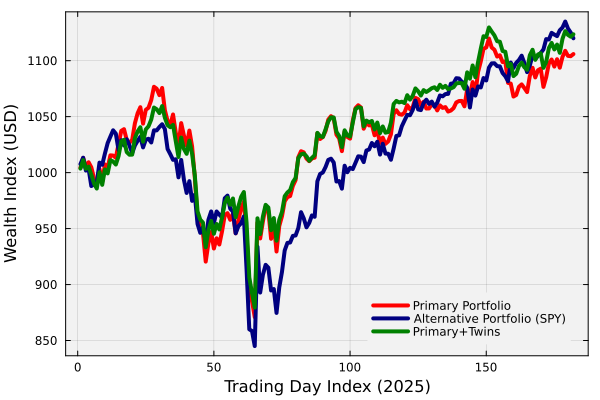

In [64]:
let

    plot(1:maximum_number_trading_days, W₁, lw=4, xlabel="Trading Day Index (2025)", 
        ylabel="Wealth Index (USD)", fontsize=18, label="Primary Portfolio", c=:red)

    plot!(1:maximum_number_trading_days, Wₐ, lw=4, xlabel="Trading Day Index (2025)", 
        ylabel="Wealth Index (USD)", fontsize=18, label="Alternative Portfolio (SPY)", c=:navy)

    plot!(1:maximum_number_trading_days, W₂, lw=4, xlabel="Trading Day Index (2025)", 
        ylabel="Wealth Index (USD)", fontsize=18, label="Primary+Twins", c=:green)


    plot!(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent);
end

In [65]:
do_I_see_the_wealth_trajectory_plot = true; # set to {true | false} if you see the wealth trajectory plot   

### Discussion Question for Task 3

__Question:__ Analyze the wealth trajectory plot above, which compares three investment strategies over the 2025 trading period:
- Primary Portfolio (red): Uses only the original ticker list with SIM-based optimization
- Primary+Twins Portfolio (green): Includes low-correlation twin assets for each primary ticker
- Alternative Portfolio (navy): Simple buy-and-hold strategy with SPY (S&P 500 ETF)

Based on the wealth trajectories shown:
1. Which portfolio strategy achieved the highest terminal wealth by the end of the period?
2. How do the volatility characteristics differ among the three strategies? Which appears most volatile?
3. Given that all three portfolios started with the same initial investment of 1000 USD, what does this tell you about the practical value of adding low-correlation assets to reduce portfolio risk?
4. Would you recommend the complexity of maintaining the Primary+Twins portfolio over the simpler SPY alternative? Justify your answer with specific observations from the wealth trajectories.

Provide your detailed analysis below, referencing specific patterns or features from the plot to support your conclusions.

__Answers here:__ Put your answers to the discussion questions for task 3 here.

In [38]:
did_I_answer_the_discussion_questions_for_task_3 = true; # set to {true | false} if you answered the discussion question

___

## Tests
The code block below shows how we implemented the tests and what we are testing. In these tests, we check values in your notebook and give feedback on which items are correct, missing, etc.

In [39]:
@testset verbose = true "CHEME 5660 PS4 Test Suite" begin

    # Task 1: Risk and Return Matrices For Low Correlation Ticker Pairs
    @testset "Task 1: Risk and Return Matrices" begin
        @testset "Primary Tickers" begin
            @test isdefined(Main, :my_primary_list_of_tickers)
            @test typeof(my_primary_list_of_tickers) == Array{String,1}
            @test length(my_primary_list_of_tickers) > 0
        end

        @testset "Correlation Matrix" begin
            @test isdefined(Main, :CM)
            @test typeof(CM) == Array{Float64,2}
            @test size(CM, 1) == size(CM, 2) == length(list_of_tickers)
        end

        @testset "Ticker Pairs" begin
            @test isdefined(Main, :my_list_of_ticker_pairs)
            @test typeof(my_list_of_ticker_pairs) == Array{Tuple{String,String},1}
            @test length(my_list_of_ticker_pairs) == length(my_primary_list_of_tickers)
        end

        @testset "Twin Tickers" begin
            @test isdefined(Main, :my_list_of_twin_tickers)
            @test typeof(my_list_of_twin_tickers) == Array{String,1}
            @test length(my_list_of_twin_tickers) == 2 * length(my_primary_list_of_tickers)
        end

        @testset "SIM Matrices Primary" begin
            @test isdefined(Main, :ĝ_sim_primary)
            @test typeof(ĝ_sim_primary) == Array{Float64,1}
            @test length(ĝ_sim_primary) == length(my_primary_list_of_tickers)
            @test isdefined(Main, :Σ̂_sim_primary)
            @test typeof(Σ̂_sim_primary) == Array{Float64,2}
            @test size(Σ̂_sim_primary) == (length(my_primary_list_of_tickers), length(my_primary_list_of_tickers))
        end

        @testset "SIM Matrices Twins" begin
            @test isdefined(Main, :ĝ_sim_twins)
            @test typeof(ĝ_sim_twins) == Array{Float64,1}
            @test length(ĝ_sim_twins) == length(my_list_of_twin_tickers)
            @test isdefined(Main, :Σ̂_sim_twins)
            @test typeof(Σ̂_sim_twins) == Array{Float64,2}
            @test size(Σ̂_sim_twins) == (length(my_list_of_twin_tickers), length(my_list_of_twin_tickers))
        end
    end

    # Task 2: Compute the efficient frontiers for your collection of tickers
    @testset "Task 2: Efficient Frontiers" begin
        @testset "Markowitz Problems" begin
            @test isdefined(Main, :problem_sim_primary)
            @test typeof(problem_sim_primary) == MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem
            @test isdefined(Main, :problem_sim_twins)
            @test typeof(problem_sim_twins) == MyMarkowitzRiskyAssetOnlyPortfolioChoiceProblem
        end

        @testset "Reward Array" begin
            @test isdefined(Main, :minimum_desired_reward_array)
            @test typeof(minimum_desired_reward_array) == Array{Float64,1}
            @test length(minimum_desired_reward_array) == 301
        end

        @testset "Efficient Frontiers" begin
            @test isdefined(Main, :efficient_frontier_sim_primary)
            @test typeof(efficient_frontier_sim_primary) == Dict{Float64, NamedTuple}
            @test length(efficient_frontier_sim_primary) > 0
            @test isdefined(Main, :efficient_frontier_sim_twins)
            @test typeof(efficient_frontier_sim_twins) == Dict{Float64, NamedTuple}
            @test length(efficient_frontier_sim_twins) > 0
        end

        @testset "Results Arrays" begin
            @test isdefined(Main, :results_array_sim_primary)
            @test typeof(results_array_sim_primary) == Array{Float64,2}
            @test size(results_array_sim_primary, 2) == length(my_primary_list_of_tickers) + 2
            @test isdefined(Main, :results_array_sim_twins)
            @test typeof(results_array_sim_twins) == Array{Float64,2}
            @test size(results_array_sim_twins, 2) == length(my_list_of_twin_tickers) + 2
        end
    end

    # Task 3: How do these portfolios perform?
    @testset "Task 3: Portfolio Performance" begin
        @testset "Desired Growth Rate" begin
            @test isdefined(Main, :desired_growth_rate)
            @test typeof(desired_growth_rate) == Float64
            @test desired_growth_rate > 0
        end

        @testset "Desired Solutions" begin
            @test isdefined(Main, :desired_solution_sim_primary)
            @test typeof(desired_solution_sim_primary) == Dict{String, Any}
            @test haskey(desired_solution_sim_primary, "status")
            @test isdefined(Main, :desired_solution_sim_twins)
            @test typeof(desired_solution_sim_twins) == Dict{String, Any}
            @test haskey(desired_solution_sim_twins, "status")
        end

        @testset "Shares" begin
            @test isdefined(Main, :n₁)
            @test typeof(n₁) == Array{Float64,1}
            @test length(n₁) == length(my_primary_list_of_tickers)
            @test isdefined(Main, :n₂)
            @test typeof(n₂) == Array{Float64,1}
            @test length(n₂) == length(my_list_of_twin_tickers)
            @test isdefined(Main, :n_alternative)
            @test typeof(n_alternative) == Float64
        end

        @testset "Wealth Trajectories" begin
            @test isdefined(Main, :W₁)
            @test typeof(W₁) == Array{Float64,1}
            @test length(W₁) == maximum_number_trading_days
            @test isdefined(Main, :W₂)
            @test typeof(W₂) == Array{Float64,1}
            @test length(W₂) == maximum_number_trading_days
            @test isdefined(Main, :Wₐ)
            @test typeof(Wₐ) == Array{Float64,1}
            @test length(Wₐ) == maximum_number_trading_days
        end

        @testset "Discussion Question" begin
            @test isdefined(Main, :did_I_answer_the_discussion_questions_task_2)
            @test did_I_answer_the_discussion_questions_task_2 == true
            @test isdefined(Main, :did_I_answer_the_discussion_questions_for_task_3)
            @test did_I_answer_the_discussion_questions_for_task_3 == true
            @test isdefined(Main, :do_I_see_the_wealth_trajectory_plot)
            @test do_I_see_the_wealth_trajectory_plot == true
        end
    end
end;

SIM Matrices Twins: Test Failed at c:\Users\katey\Documents\GitHub\ps1-5660-f25-KatlynMouliaArriola\cheme-5660-classroom-cornell-ps4-5660-f25-PS4-CHEME-5660-TEMPLATE-F2025\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y145sZmlsZQ==.jl:39
  Expression: isdefined(Main, :ĝ_sim_twins)

Stacktrace:
 [1] macro expansion
   @ C:\Users\katey\.julia\juliaup\julia-1.11.6+0.x64.w64.mingw32\share\julia\stdlib\v1.11\Test\src\Test.jl:680 [inlined]
 [2] macro expansion
   @ c:\Users\katey\Documents\GitHub\ps1-5660-f25-KatlynMouliaArriola\cheme-5660-classroom-cornell-ps4-5660-f25-PS4-CHEME-5660-TEMPLATE-F2025\jl_notebook_cell_df34fa98e69747e1a8f8a730347b8e2f_Y145sZmlsZQ==.jl:39 [inlined]
 [3] macro expansion
   @ C:\Users\katey\.julia\juliaup\julia-1.11.6+0.x64.w64.mingw32\share\julia\stdlib\v1.11\Test\src\Test.jl:1709 [inlined]
 [4] macro expansion
   @ c:\Users\katey\Documents\GitHub\ps1-5660-f25-KatlynMouliaArriola\cheme-5660-classroom-cornell-ps4-5660-f25-PS4-CHEME-5660-TEMPLATE-F2025\jl_noteb

TestSetException: Some tests did not pass: 46 passed, 10 failed, 19 errored, 0 broken.

___

## Disclaimer and Risks
__This content is offered solely for training and informational purposes__. No offer or solicitation to buy or sell securities or derivative products or any investment or trading advice or strategy is made, given, or endorsed by the teaching team. 

__Trading involves risk__. Carefully review your financial situation before investing in securities, futures contracts, options, or commodity interests. Past performance, whether actual or indicated by historical tests of strategies, is no guarantee of future performance or success. Trading is generally inappropriate for someone with limited resources, investment or trading experience, or a low-risk tolerance. Only risk capital that is not required for living expenses should be used.

__You are fully responsible for any investment or trading decisions you make__. You should decide solely based on your financial circumstances, investment or trading objectives, risk tolerance, and liquidity needs.